## Data preparation and sanitization

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")
df = df.dropna()
## Usable columns: ['time_spent_risk', 'cells', 'selfish', 'time_spent_prop', 'count_effort', 
## 'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']
#df["effort"] = (1/df['time_spent_prop'] ) * (1/df['count_effort'])
df_effort = df[['time_spent_prop', 'count_effort']]
df_effort = (df_effort - df_effort.min()) / (df_effort.max() - df_effort.min())

df['effort'] = df_effort['time_spent_prop'] * df_effort['count_effort']
df = df[['time_spent_risk', 'cells', 'selfish', 'effort',
         'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

df = df[['selfish','Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

MAX_ACCEPTABLE_MIN_OFFER = 150
df = df[df['min_offer'] <= MAX_ACCEPTABLE_MIN_OFFER]

NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
MAX_GAIN = 200


#### Benchmark

In [3]:
from utils.benchmark import process_benchmarks, process_benchmark_cv, process_model


ADD path: </home/franck/Desktop/MA-Thesis/code>
['', '/home/franck/anaconda3/lib/python36.zip', '/home/franck/anaconda3/lib/python3.6', '/home/franck/anaconda3/lib/python3.6/lib-dynload', '/home/franck/anaconda3/lib/python3.6/site-packages', '/home/franck/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/franck/.ipython', '/home/franck/Desktop/MA-Thesis/code']
/home/franck/Desktop/MA-Thesis/code/notebooks/utils/data_augmentation.py


Using TensorFlow backend.


**Keras Model**

In [26]:
from models import KerasModel, loss_tf, gain_tf

In [27]:
import os, sys


In [6]:
# #sci-kit like training
# sm = keras_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

**Featureless model (fixed value)**

In [7]:
from models import FeaturelessModel

**Convervative model**

In [8]:
from models import ConservativeModel

**Linear/Logistic regression**

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

**Random**

In [10]:
from models import RandomModel

**Random Forest**

In [11]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [12]:
from models import ClusterModel, ClusterExtModel

** Acceptance model **

In [13]:
from models import AcceptanceModel

** Data augmentation **

In [14]:
from utils.data_augmentation import DACombine

**Baseline models**

In [29]:
from sklearn.svm import SVC

benchmark_models = {
    #Featureless:
    #"random": RandomModel(MAX_GAIN),
    #"conservative": ConservativeModel(MAX_GAIN),
    "featureless": FeaturelessModel(MAX_GAIN),
    "svc": SVC(gamma='auto') 
#     "linear_regressor": LinearRegression(copy_X=False),
#     "linear_regressor_mse": keras_linear_regression(loss="mse"),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
featureless,27.001587,0.213637,24.000891,962.0,1517.492063,0.061587
featureless_da2,38.511905,0.307712,36.658874,1371.0,2280.837302,0.050317
svc,27.001587,0.213637,24.000891,962.0,1517.492063,0.061587
svc_da2,84.006349,0.717400,42.874603,2990.0,9295.809524,0.606508


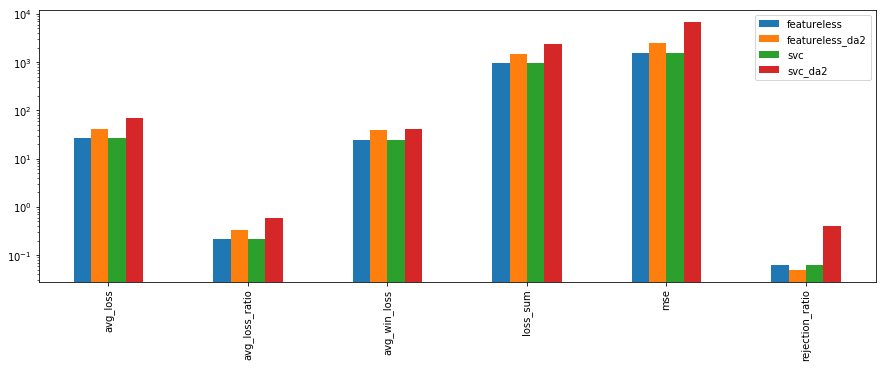

In [16]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [19]:
benchmark_models = {
#     #Cluster-based
    "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
}

results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
affinity,35.692222,0.292489,30.335308,1272.6,2191.710317,0.100476
affinity_ext,29.547619,0.236782,25.861464,1053.0,1704.460317,0.072698
meanshift,32.607619,0.258506,30.719481,1161.4,1777.692698,0.050317
meanshift_ext,27.573016,0.219080,24.102217,982.0,1580.349206,0.067302


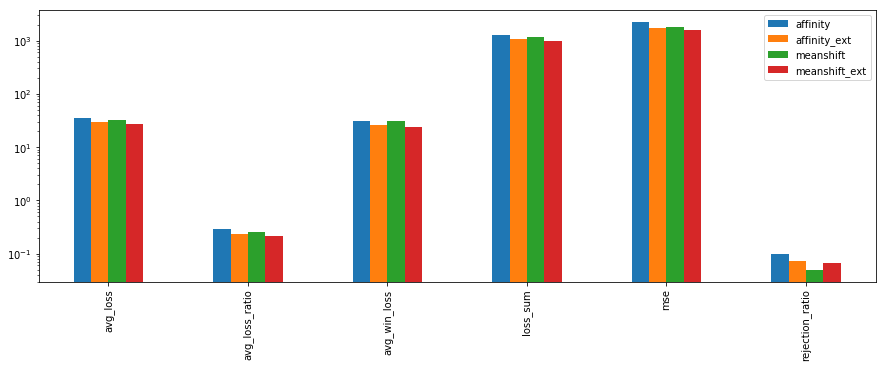

In [20]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [21]:
benchmark_models = {
    'featureless': FeaturelessModel(),
    # Regression
    #"random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    #"nn_regression_mse": keras_model(loss="mse"),
    #"nn_regression_ext": keras_model(loss=loss_tf),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
acceptance_model,28.779365,0.229611,25.471535,1026.0,1639.158730,0.067143
acceptance_model_da2,39.117460,0.331113,30.581663,1396.0,2606.571429,0.150476
featureless,27.001587,0.213637,24.000891,962.0,1517.492063,0.061587
featureless_da2,38.315873,0.306289,36.658874,1363.0,2223.730159,0.050317
logistic_regression,27.017460,0.214933,23.401070,962.0,1550.428571,0.067302
logistic_regression_da2,77.947619,0.675107,42.737939,2773.0,7925.682540,0.522857


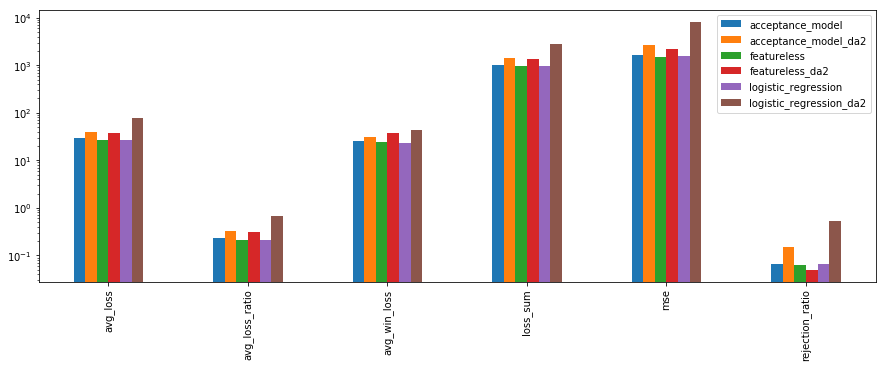

In [22]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**TOP MODELS**

In [34]:
benchmark_models = {
    'featureless': FeaturelessModel(),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    'svc': SVC(gamma='auto'),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None, shuffle=True)
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
acceptance_model,28.769048,0.229593,25.920699,1026.0,1588.130952,0.061746
featureless,26.972222,0.213643,24.009117,962.0,1515.654762,0.061905
logistic_regression,32.369048,0.266247,24.008028,1152.0,2180.337302,0.124286
svc,26.972222,0.213643,24.009117,962.0,1515.654762,0.061905


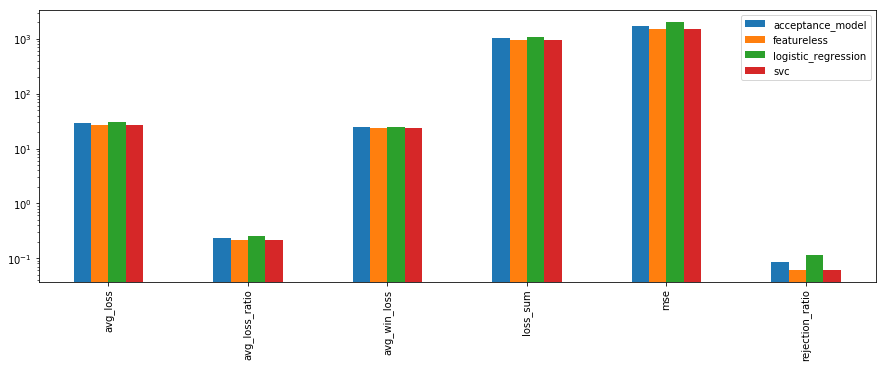

In [24]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))